In [ ]:
# install required dependencies

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !pip install control
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 1.9 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=35cc2c4df41bd7932b18760f6c9ca19229b8a0cb1522866d65489e147c4d6070
  Stored in directory: /root/.cache/pip/wheels/dc/0b/33/e063a044f930977e4897732d007122648d9db0e50934094040
Successfully built polytope
     |████████████████████████████████| 11.1 MB 9.3 MB/s 
     |████████████████████████████████| 49 kB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 5.3 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=216d5e6d6d4e3232f5cfa54137fc7231535c03b2bd88034e2b4a3faa554316bb
  Stored in directory: /root/.cache/pip/wheels/a6/3d/b3/8c508e66f4d44cf71b9ec49b94d4a074c8f2ee52475cd8920e
Successfully built con

In [ ]:
import polytope as pt
import numpy as np
# from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt
# %matplotlib widget
import scipy.signal
import scipy.linalg as la
# SciPy

def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    # model.nf = np.size(Af, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    # model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    # model.Af = Af
    # model.bf = bf
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)

    x_bar = np.array([2.75,3,-np.pi/4,0,0,.5])
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t]-x_bar[i]) * model.Q[i, j] * (model.x[j, t]-x_bar[j]) 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += (model.x[i, model.N]-x_bar[i]) * model.P[i, j] * (model.x[j, model.N]-x_bar[j])
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    # Initial Cond Constraints
    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    model.init_const3 = pyo.Constraint(expr = model.x[2, 0] == x0[2])
    model.init_const4 = pyo.Constraint(expr = model.x[3, 0] == x0[3])
    model.init_const5 = pyo.Constraint(expr = model.x[4, 0] == x0[4])
    model.init_const6 = pyo.Constraint(expr = model.x[5, 0] == x0[5])
    
    
    # State and Input Constraints
    model.constraint100 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[0, t] >= xL[0])
    model.constraint200 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[0, t] <= xU[0])
    model.constraint300 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[1, t] >= xL[1])
    model.constraint400 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[1, t] <= xU[1])
    model.constraint500 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[2, t] >= xL[2])
    model.constraint600 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[2, t] <= xU[2])
    model.constraint700 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[3, t] >= xL[3])
    model.constraint800 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[3, t] <= xU[3])
    model.constraint900 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[4, t] >= xL[4])
    model.constraint1000 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[4, t] <= xU[4])
    model.constraint1100 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[5, t] >= xL[5])
    model.constraint1200 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.x[5, t] <= xU[5])
    model.constraint1700 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[0, t] >= uL[0])
    model.constraint1800 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[0, t] <= uU[0])
    model.constraint1900 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[1, t] >= uL[1])
    model.constraint2000 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[1, t] <= uU[1]) 
    model.constraint2100 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[2, t] >= uL[2])
    model.constraint2200 = pyo.Constraint(model.tIDX,
                                     rule=lambda model, t: model.u[2, t] <= uU[2]) 
    #constraints for not going into circle
    rt=1
    
    model.constraint2300 = pyo.Constraint(model.tIDX,
                                      rule=lambda model, t: (model.x[0, t]-3.5)**2+(model.x[1, t]-3.5)**2 >= rt**2) 
    
    # def final_const_rule(model, i):
    #     return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i] 
    
    # model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)
    
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

[[ 5.       5.       4.99139  4.97481  4.95086  4.92014  4.88322  4.84063
   4.79289  4.74052  4.68398  4.62375  4.56025  4.49391  4.42514  4.35431
   4.28181  4.20797  4.13313  4.05763  3.98176  3.90583  3.8301   3.75487
   3.68038  3.60689  3.53463  3.46385  3.39476  3.32759  3.26255  3.19984
   3.13966  3.08221  3.02768  2.97627  2.92812  2.88312  2.84117  2.80215
   2.76597  2.7325   2.70165  2.67331  2.64736  2.6237   2.60223  2.58284
   2.56543  2.54989  2.53614  2.52407  2.51359  2.50461  2.49703  2.49078
   2.48577  2.48191  2.47913  2.47735  2.4765   2.47651  2.47731  2.47883
   2.48102  2.48381  2.48715  2.49099  2.49526  2.49994  2.50496  2.51029
   2.51588  2.5217   2.5277   2.53387  2.54016  2.54654  2.55299  2.55948
   2.566    2.57251  2.579    2.58545  2.59184  2.59816  2.60441  2.61055
   2.61659  2.62252  2.62833  2.63402  2.63957  2.64499  2.65027  2.65541
   2.66042  2.66529  2.67002  2.67461  2.67908]
 [ 5.       5.       4.99688  4.99097  4.9826   4.97207  4.95965

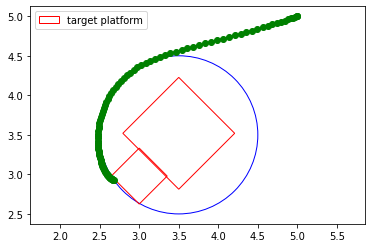

In [ ]:
m = 4000
r = 30
iz = m* (r**2)
Ts = 2
N = 100

A_0 = np.zeros((3,3))
A_eye = np.eye(3)
A_first3 = np.hstack((A_0, A_eye))
A_last3 = np.hstack((A_0, A_0))
A = np.vstack((A_first3, A_last3))
A_d = np.eye(6) + (Ts * A)

B_bottom = np.array([[1/m, 0, 0], [0, 1/m, 0], [0, 0, 1/iz]])
B = np.vstack((A_0, B_bottom))
B_d = Ts*B

xu = np.array([100, 100, 2*np.pi, 100, 100, 10])
xl = np.array([-100, -100, -2*np.pi, -100, -100, -10])
uu = np.array([15, 15, 3])
ul = np.array([-15, -15, -3])

Q = np.diag((10, 10, 10, 300, 300, 500))
R = np.eye(3)
P = scipy.linalg.solve_discrete_are(A_d, B_d, Q, R)

# print(P)

x0 = np.array([5, 5, 0, 0, 0, 0])
Af=np.array([0,0])
bf=np.array([0,0])
model, feas, xOpt, uOpt, JOpt = solve_cftoc(A_d, B_d, P, Q, R, N, x0, xl, xu, ul, uu,bf,Af)

x = xOpt[0]
y = xOpt[1]
theta = xOpt[2]
v_x = xOpt[3]
v_y = xOpt[4]
theta_dot=xOpt[5]

print(xOpt)
circle1 = plt.Circle((3.5, 3.5), 1, fc='None', ec='blue')
rectangle1 = plt.Rectangle((3.5,2.8125), 1, 1, fc='None', ec="red", angle=45, label='target platform')
rectangle2 = plt.Rectangle((3,2.625), 0.5, 0.5, fc='None', ec="red", angle=45)
fig, ax = plt.subplots() 
ax.add_patch(circle1)
ax.add_patch(rectangle1)
ax.add_patch(rectangle2)
plt.axis("equal")
plt.legend()
plt.plot(x, y, color='green',marker='o')

In [ ]:
from matplotlib.animation import FuncAnimation

error= [[93.32795]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]]


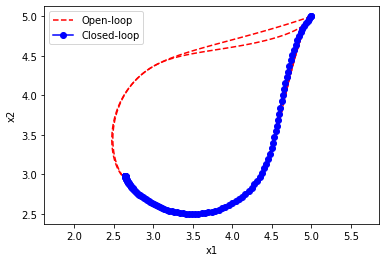

In [ ]:
##MPC Simulation
M = 150
xOpt = np.zeros((6, M+1))
uOpt = np.zeros((3, M))
x0 = np.array([5, 5, 0, 0, 0, 0])
xOpt[:, 0] = x0.reshape(6, )
feas = np.zeros((M, ), dtype=bool)
xPred = np.zeros((6, N+1, M))
predErr = np.zeros((1, M-N+1))

for t in range(M):
    [model, feas[t], x, u, J] = solve_cftoc(A_d, B_d, P, Q, R, N, xOpt[:,t], xl, xu, ul, uu, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, t] = x
    # Save open loop predictions
    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(3, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

  # Find the prediction error
for time in range(len(predErr)):
    err = xOpt[:, time:time+N+1] - xPred[:,:, time]
    sum_ = 0
    for k in range(err.shape[1]):
      sum_ += np.linalg.norm(err[:,k])
    predErr[:, time] = sum_

print('error=', predErr.T)


In [ ]:
print(feas.size)